# Assignment2

## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,datasets, models
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

import numpy as np

from sklearn.model_selection import train_test_split

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip
import matplotlib.pyplot as plt

import time


## parameter

In [2]:
VISUAL_BACKBONE = ['RN50','RN101','ViT-B/16','ViT-B/32','ViT-L/14']
prompt = 'a photo of a' # you can try different prompt

## Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(size = 224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  
])
dataset = datasets.ImageFolder(root='mydata', transform=transform)
targets = [i[1] for i in dataset.imgs]  # 提取所有图片的标签

# 划分数据集（使用分层抽样）
train_idx, test_idx = train_test_split(range(len(targets)), test_size=0.2, stratify=targets, random_state=42)

# 根据索引创建子集
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = ['cardboard','glass','metal','paper','plastic','trash']
dataset_name = 'garbage'

## Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## model

In [5]:
def prompt_encode(prompt):
    
    text_inputs = torch.cat([clip.tokenize(f"{prompt} {c} {'garbage'} ") for c in class_names]).to(device) 
    
    return text_inputs

In [6]:
def model_inference(model, image, text_inputs):
    
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
        logits,_=model(image,text_inputs)


    return logits

In [7]:
def training(model,name):
    testing_loss = []
    testing_acc = []

    with torch.no_grad():
        model.eval()

        ##################### Write your answer here ##################
        var_correct = 0
        for image,target in test_loader:
            image = image.to(device)
            target = target.to(device)
            _,preds=torch.max(model_inference(model,image,prompt_encode(prompt)),1)
            var_correct+=torch.sum(preds==target.data)
        val_acc=var_correct/len(test_dataset)   

        ###############################################################

        print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {name}.")
        return (val_acc*100).cpu()



In [8]:
acc = []
times = []
for name in VISUAL_BACKBONE:
    start_time = time.time()
    model, preprocess = clip.load(name=name, device=device, download_root='/shareddata/clip/')
    model.to(device)
    acc.append(training(model,name))
    end_time = time.time()  # 记录循环结束的时间
    iteration_time = end_time - start_time  # 计算迭代所需时间
    times.append(iteration_time)  # 将迭代时间添加到列表中
    print(f'use {iteration_time:.4f} to finish test')

the zero-shot performance on garbage is 61.39%, visual encoder is RN50.
use 14.3849 to finish test
the zero-shot performance on garbage is 59.07%, visual encoder is RN101.
use 16.7077 to finish test
the zero-shot performance on garbage is 67.72%, visual encoder is ViT-B/16.
use 15.1356 to finish test
the zero-shot performance on garbage is 71.52%, visual encoder is ViT-B/32.
use 12.5795 to finish test
the zero-shot performance on garbage is 77.85%, visual encoder is ViT-L/14.
use 27.0900 to finish test


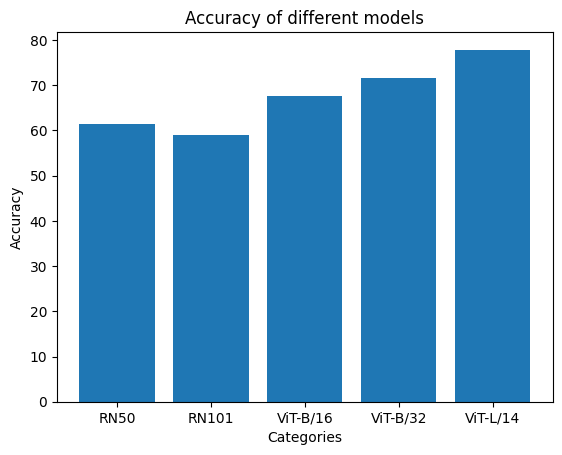

In [9]:
# 创建柱状图
plt.bar(VISUAL_BACKBONE, acc)

# 添加标题和标签
plt.title('Accuracy of different models')
plt.xlabel('Categories')
plt.ylabel('Accuracy')

# 显示图表
plt.show()

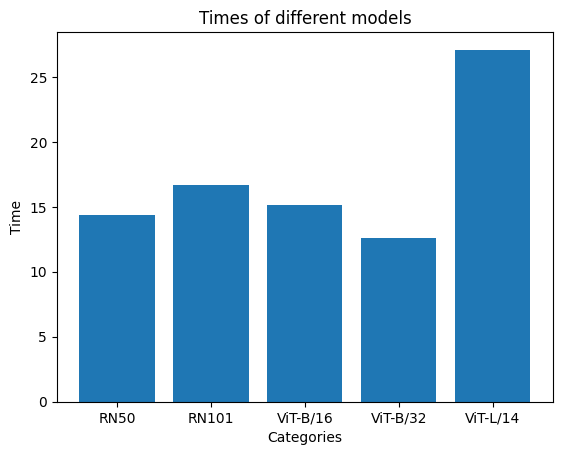

In [10]:
# 创建柱状图
plt.bar(VISUAL_BACKBONE, times)

# 添加标题和标签
plt.title('Times of different models')
plt.xlabel('Categories')
plt.ylabel('Time')

# 显示图表
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


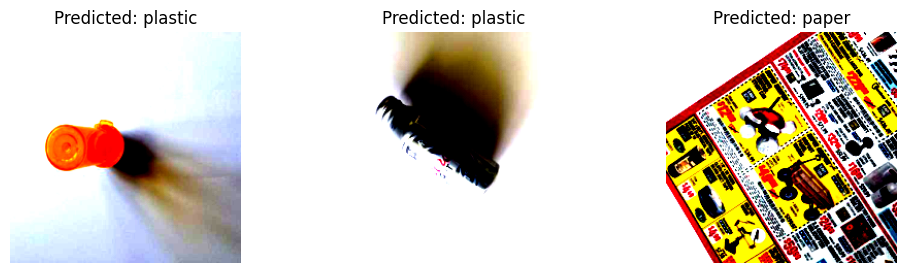

In [11]:
with torch.no_grad():
    model.eval()
    image, target = next(iter(test_loader))
    image = image.to(device)
    target = target.to(device)
    _,preds=torch.max(model_inference(model,image,prompt_encode(prompt)),1)
    image = image.cpu()
    preds = preds.cpu()

    # 设置 Matplotlib 图表
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    # 遍历前四张图片及其预测结果
    for i in range(3):
        img = image[i].numpy().transpose(1, 2, 0)  # 将张量转换为 HxWxC 形式
        pred_class = class_names[preds[i]]  # 获取预测的类别名称

        # 显示图片
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {pred_class}")
        axes[i].axis('off')

    plt.show()